In [1]:
from pathlib import Path
from random import gauss

import torch
from configs.base import BaseConfig
from datasets.coco_albumentations import CocoTrainDataset, CocoValDataset

cfg = BaseConfig()
cfg.data_dir = Path("../data/coco2014")
cfg.val_data_dir = Path("../data/coco2014")

dset = CocoTrainDataset(
    cfg=cfg,
    device=torch.device("cuda:0")
)
test_dset = CocoValDataset(
    cfg=cfg,
    device=torch.device("cuda:0")
)

loading annotations into memory...
Done (t=4.87s)
creating index...
index created!
Serializing 82783 elements to byte tensors and concatenating them all ...
Serialized dataset takes 46.88 MiB
loading annotations into memory...
Done (t=1.88s)
creating index...
index created!
Serializing 40504 elements to byte tensors and concatenating them all ...
Serialized dataset takes 22.62 MiB


In [13]:
item = dset[2]

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import torch.nn.functional as F


def plot_image_with_boxes(image, boxes):
    fig, ax = plt.subplots(1)
    ax.imshow(image, cmap="gray" if image.ndim == 2 else None)
    colors = ["red", "blue", "yellow", "green", "purple", "orange", "cyan", "magenta"]
    for i, box in enumerate(boxes):
        if len(box) != 4:
            continue
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        if width <= 0 or height <= 0:
            continue
        rect = patches.Rectangle(
            (x_min, y_min),
            width,
            height,
            linewidth=1,
            edgecolor=colors[i % len(colors)],
            facecolor="none",
        )
        ax.add_patch(rect)

    plt.show()


def plot_corner_heatmaps(tl_hmap, br_hmap, image=None, alpha=0.5):
    """Visualize aggregated CornerNet TL/BR heatmaps and optionally overlay on the image."""
    tl_hmap = tl_hmap.detach().float().cpu()
    br_hmap = br_hmap.detach().float().cpu()

    tl_agg = tl_hmap.max(dim=0).values.numpy()
    br_agg = br_hmap.max(dim=0).values.numpy()

    show_image = image is not None
    ncols = 3 if show_image else 2
    fig, axes = plt.subplots(1, ncols, figsize=(5 * ncols, 5))

    if not isinstance(axes, (list, tuple, np.ndarray)):
        axes = [axes]

    axes[0].set_title("Top-left heatmap (max over classes)")
    im0 = axes[0].imshow(tl_agg, cmap="hot")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    axes[1].set_title("Bottom-right heatmap (max over classes)")
    im1 = axes[1].imshow(br_agg, cmap="hot")
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    if show_image:
        if isinstance(image, torch.Tensor):
            img = image.detach().cpu()
        else:
            img = torch.from_numpy(image).permute(2, 0, 1)

        heatmap_tensor = torch.stack([tl_hmap.max(dim=0).values, br_hmap.max(dim=0).values], dim=0)
        heatmap_tensor = heatmap_tensor.unsqueeze(0)
        resized_heatmaps = F.interpolate(
            heatmap_tensor,
            size=(img.shape[1], img.shape[2]),
            mode="bilinear",
            align_corners=False,
        ).squeeze(0)

        overlay = img.clone().float()
        overlay = overlay - overlay.min()
        if overlay.max() > 0:
            overlay = overlay / overlay.max()

        overlay = overlay.permute(1, 2, 0).numpy()
        tl_overlay = resized_heatmaps[0].numpy()
        br_overlay = resized_heatmaps[1].numpy()

        axes[2].set_title("Image with TL/BR overlays")
        axes[2].imshow(overlay)
        axes[2].imshow(tl_overlay, cmap="Reds", alpha=alpha)
        axes[2].imshow(br_overlay, cmap="Blues", alpha=alpha)
        axes[2].axis("off")

    plt.tight_layout()
    plt.show()


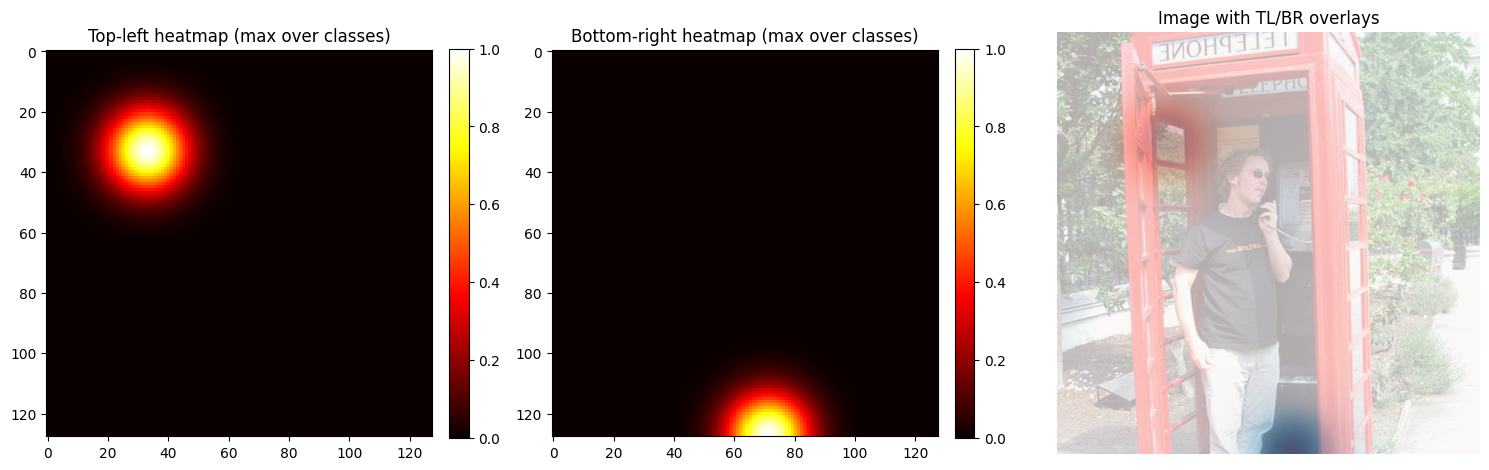

In [15]:
plot_corner_heatmaps(
    tl_hmap=item["tl_hmap"],
    br_hmap=item["br_hmap"],
    image=item["image"],
    alpha=0.45,
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6894774..1.7233243].


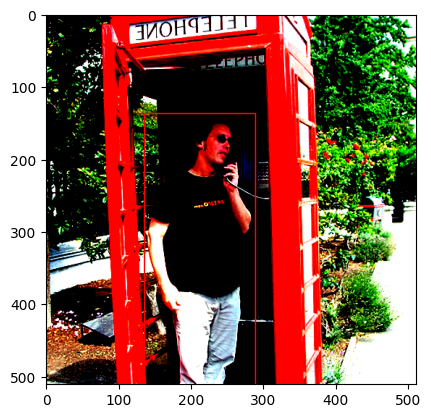

In [16]:
plot_image_with_boxes(
    item["image"].cpu().numpy().transpose(1, 2, 0),
    item["bboxes"].cpu().numpy(),
)

In [6]:
from nets.hourglass import CornerNet

model = CornerNet(n=5, nstack=1, dims=[256, 256, 384, 384, 384, 512], num_modules=[2, 2, 2, 2, 2, 4])

In [7]:
import torch
out = model(torch.rand(2, 3, 511, 511))

IndexError: too many indices for tensor of dimension 4